In [ ]:
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import re

In [ ]:
# Dataset Preparation

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=train_transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=base_transform)

train_size = int(0.9 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train_set, mnist_val_set = random_split(mnist_train, [train_size, val_size])

sample, target = mnist_train[0]
print(f"Sample count: {len(mnist_train)}")
print(f"Sample shape: {sample.shape}, Target: {target}")
print(f"Sample type: {sample.dtype}, Target type: {type(target)}")
print(f"Sample min: {sample.min()}, Sample max: {sample.max()}")
print(f"Sample training set size: {len(mnist_train_set)}")
print(f"Sample validation set size: {len(mnist_val_set)}")

In [ ]:
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

cifar10_train = datasets.CIFAR10(root='data', train=True, download=True, transform=base_transform)
cifar10_test = datasets.CIFAR10(root='data', train=False, download=True, transform=base_transform)

train_size = int(0.9 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
cifar10_train_set, cifar10_val_set = random_split(cifar10_train, [train_size, val_size])

sample, target = cifar10_train_set[0]
print(f"Sample count: {len(cifar10_train)}")
print(f"Test count: {len(cifar10_test)}")
print(f"Sample shape: {sample.shape}, Target: {target}")
print(f"Sample type: {sample.dtype}, Target type: {type(target)}")
print(f"Sample min: {sample.min()}, Sample max: {sample.max()}")
print(f"Sample training set size: {len(cifar10_train_set)}")
print(f"Sample validation set size: {len(cifar10_val_set)}")

In [ ]:
class Hymmn0s_LeNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=1, input_size=28):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(input_channels, 6, kernel_size=5, stride=1, padding=int((32-input_size)//2)),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6,16, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16,120, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        return self.stack(x)

In [ ]:
def train(model, train_dataset, val_dataset, model_name):
    lr = 0.001
    epochs = 50
    batch = 128
    weight_decay = 2e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr*10, epochs=epochs, steps_per_epoch=len(train_dataset)//batch)
    loss_fn = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch, shuffle=False)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * data.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{model_name}_epoch_{epoch+1}.pth")
            print(f"Model saved at epoch {epoch+1}")
        with torch.no_grad():
            correct = 0
            total = 0
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_accuracy = correct / total
            print(f"Validation Accuracy: {val_accuracy:.4f}")



def test(model, test_dataset):
    batch = 256
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


In [ ]:
mnist_LeNet_model = Hymmn0s_LeNet(10,1,28).to('cuda' if torch.cuda.is_available() else 'cpu')

train(mnist_LeNet_model,mnist_train_set,mnist_val_set,"mnist_LeNet_model")

In [ ]:
cifar10_LeNet_model = Hymmn0s_LeNet(10,3,32).to('cuda' if torch.cuda.is_available() else 'cpu')

train(cifar10_LeNet_model,cifar10_train_set,cifar10_val_set,"cifar10_LeNet_model")

In [ ]:
mnist_AlexNet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

mnist_train = datasets.MNIST(root='data', train=True, download=False, transform=mnist_AlexNet_transform)
mnist_test = datasets.MNIST(root='data', train=False, download=False, transform=mnist_AlexNet_transform)

train_size = int(0.9 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train_set, mnist_val_set = random_split(mnist_train, [train_size, val_size])

sample, target = mnist_train_set[0]
print(f"Sample count: {len(cifar10_train)}")
print(f"Test count: {len(cifar10_test)}")
print(f"Sample shape: {sample.shape}, Target: {target}")

In [ ]:
cifar10_AlexNet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

cifar10_train = datasets.CIFAR10(root='data', train=True, download=False, transform=cifar10_AlexNet_transform)
cifar10_test = datasets.CIFAR10(root='data', train=False, download=False, transform=cifar10_AlexNet_transform)

train_size = int(0.9 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
cifar10_train_set, cifar10_val_set = random_split(cifar10_train, [train_size, val_size])

sample, target = cifar10_train_set[0]
print(f"Sample count: {len(cifar10_train)}")
print(f"Test count: {len(cifar10_test)}")
print(f"Sample shape: {sample.shape}, Target: {target}")

In [ ]:
class Hymmn0s_AlexNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3, input_size=32):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(input_channels, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.stack(x)

In [ ]:
mnist_AlexNet_model = Hymmn0s_AlexNet(10,1,224).to('cuda' if torch.cuda.is_available() else 'cpu')

train(mnist_AlexNet_model, mnist_train_set, mnist_val_set,"mnist_AlexNet_model")

In [ ]:
cifar10_AlexNet_model = Hymmn0s_AlexNet(10,3,224).to('cuda' if torch.cuda.is_available() else 'cpu')

train(cifar10_AlexNet_model, cifar10_train_set, cifar10_val_set,"cifar10_AlexNet_model")

In [ ]:
def draw_log(path, title):
    with open(path, 'r') as f:
        log_text = f.read()

    lines = log_text.strip().split('\n')
    pattern = r'Epoch (\d+)/\d+.*?Loss: ([\d.]+).*?Validation Accuracy: ([\d.]+)'
    matches = re.findall(pattern, log_text, re.DOTALL)

    epochs = [int(m[0]) for m in matches]
    losses = [float(m[1]) for m in matches]
    val_acc = [float(m[2]) for m in matches]

    plt.figure(figsize=(10, 5))
    plt.suptitle(title, fontsize=14, y=-0.02)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(['Loss'])
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc, marker='o')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(['Accuracy'])
    plt.tight_layout()
    plt.show()

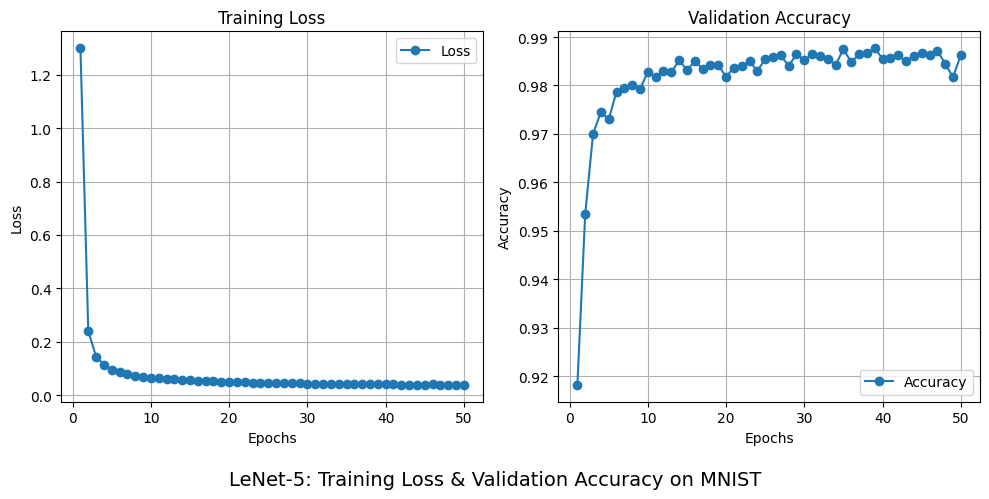

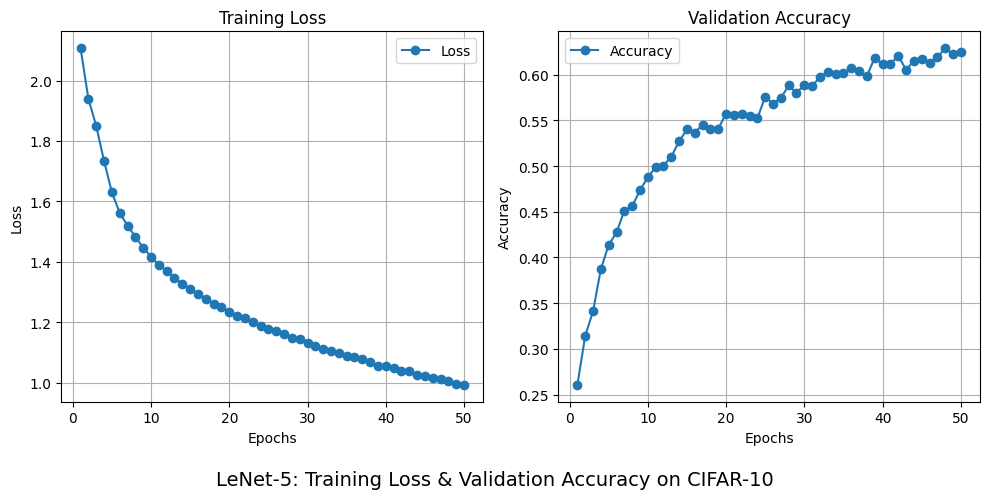

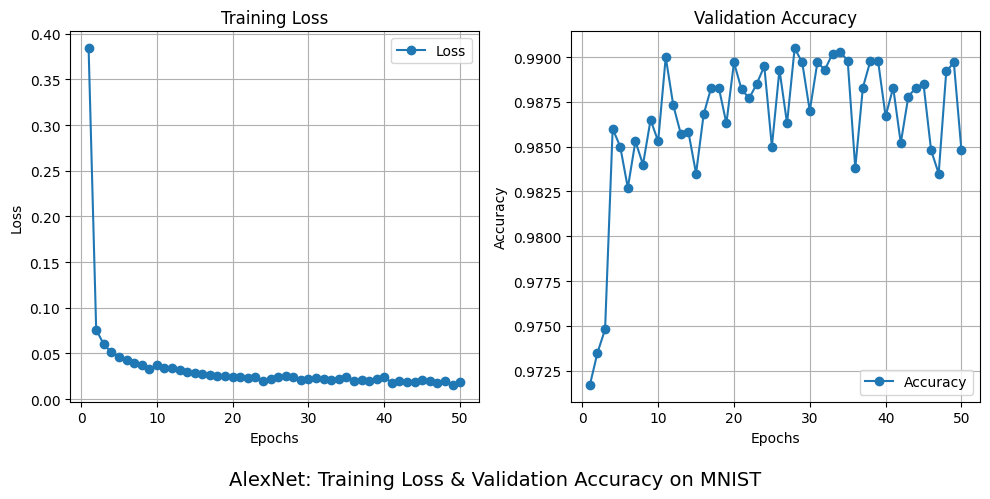

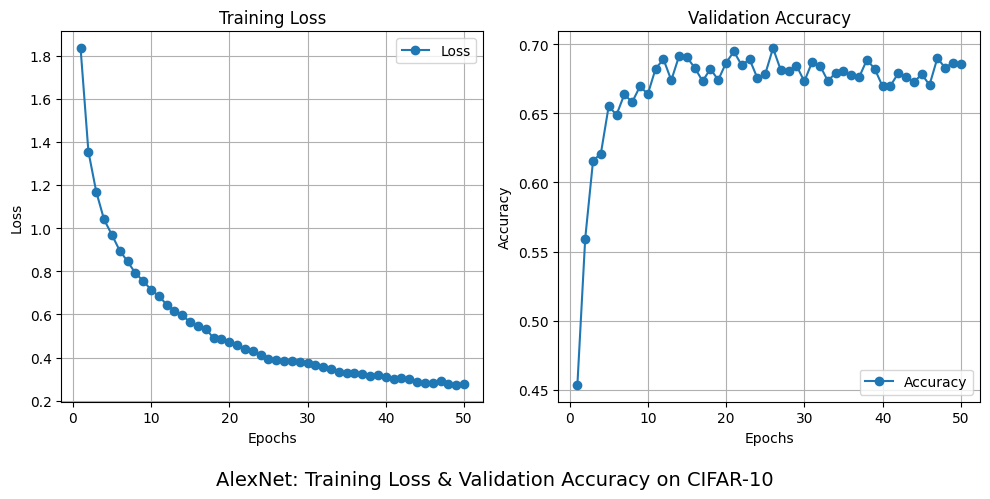

In [40]:
log_path_list = [
    "mnist_LeNet.log",
    "cifar10_LeNet.log",
    "mnist_AlexNet.log",
    "cifar10_AlexNet.log"
]
title = [
    "LeNet-5: Training Loss & Validation Accuracy on MNIST",
    "LeNet-5: Training Loss & Validation Accuracy on CIFAR-10",
    "AlexNet: Training Loss & Validation Accuracy on MNIST",
    "AlexNet: Training Loss & Validation Accuracy on CIFAR-10"
]

for i in range(len(log_path_list)):
    draw_log("log/"+log_path_list[i], title[i])